## Univariate roc-auc or mse

This procedure works as follows:

- First, it builds one decision tree per feature, to predict the target
- Second, it makes predictions using the decision tree and the mentioned feature
- Third, it ranks the features according to the machine learning metric (roc-auc or mse)
- It selects the highest ranked features

Here we will see how to select features based on univariate roc-auc or univariate mse information on a regression and classification problem. For classification we will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

In [2]:
# load dataset
data = pd.read_csv('paribas.csv', nrows=50000)
data.shape

(50000, 133)

In [3]:
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,...,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,...,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,...,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,...,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,...,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [4]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity we will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(50000, 114)

### Important

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [5]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target', 'ID'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 112), (15000, 112))

In [6]:
# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set

roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

In [7]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False)

v10     0.624634
v50     0.589416
v14     0.579966
v129    0.573197
v62     0.566037
v72     0.539332
v12     0.529848
v21     0.518259
v38     0.515919
v70     0.514612
v29     0.514408
v2      0.512774
v42     0.512631
v6      0.512163
v105    0.511900
v89     0.511822
v67     0.511266
v27     0.511147
v54     0.511057
v83     0.510953
v48     0.510883
v57     0.510784
v20     0.510683
v100    0.510558
v68     0.510383
v111    0.510075
v49     0.509982
v9      0.509947
v34     0.509873
v116    0.509557
          ...   
v39     0.502556
v59     0.502472
v23     0.502464
v86     0.502414
v44     0.502396
v92     0.502262
v33     0.502238
v93     0.502204
v94     0.502164
v97     0.502094
v76     0.501811
v65     0.501622
v40     0.501542
v46     0.501280
v25     0.500853
v84     0.500379
v119    0.499927
v7      0.499769
v82     0.499660
v32     0.499569
v95     0.499223
v102    0.498497
v118    0.498376
v131    0.497961
v73     0.497150
v109    0.496780
v85     0.496770
v18     0.4966

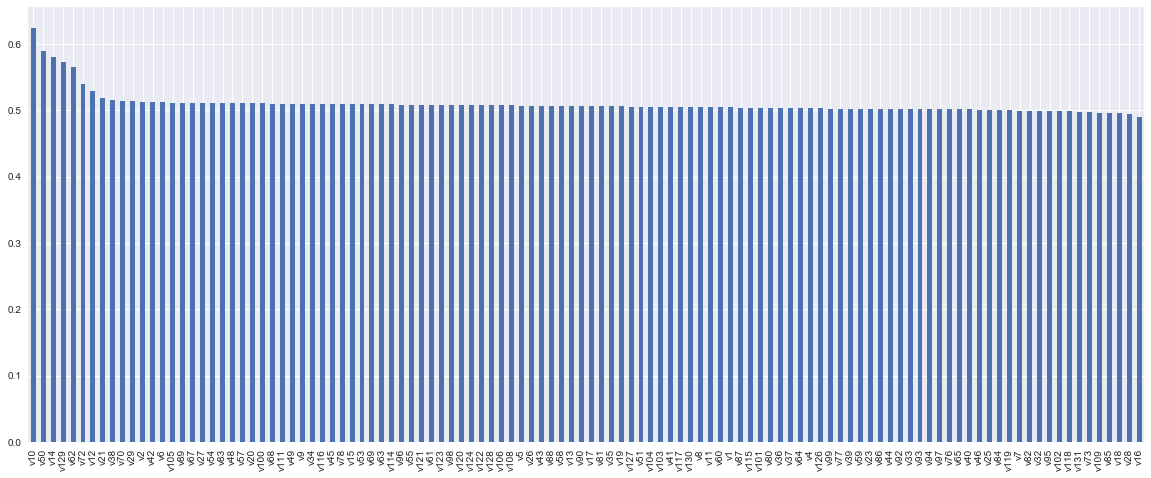

In [8]:
# and now let's plot
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [10]:
# a roc auc value of 0.5 indicates random decision
# let's check how many features show a roc-auc value
# higher than random

len(roc_values[roc_values > 0.5])

98

98 of 112  features show a predictive performance higher than 0.5. This means that we could remove 14 features from this dataset using this method.

### Regression

In [11]:
# load dataset
data = pd.read_csv('houseprice.csv')
data.shape

(1460, 81)

In [12]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity we will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [13]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 37), (438, 37))

In [14]:
# loop to build a tree, make predictions and get the mse
# for each feature of the train set
mse_values = []
for feature in X_train.columns:
    clf = DecisionTreeRegressor()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict(X_test[feature].fillna(0).to_frame())
    mse_values.append(mean_squared_error(y_test, y_scored))

In [15]:
# let's add the variable names and order it for clearer visualisation
mse_values = pd.Series(mse_values)
mse_values.index = X_train.columns
mse_values.sort_values(ascending=False)

Id               1.326803e+10
BsmtUnfSF        1.011789e+10
LotArea          8.379937e+09
MasVnrArea       7.867109e+09
BsmtFinSF1       7.696158e+09
WoodDeckSF       7.271460e+09
3SsnPorch        6.948829e+09
OpenPorchSF      6.886315e+09
MoSold           6.875928e+09
YrSold           6.832078e+09
LotFrontage      6.827291e+09
PoolArea         6.816711e+09
BsmtFinSF2       6.806977e+09
BsmtHalfBath     6.798179e+09
EnclosedPorch    6.797342e+09
MiscVal          6.791047e+09
LowQualFinSF     6.764285e+09
ScreenPorch      6.707080e+09
KitchenAbvGr     6.665297e+09
BedroomAbvGr     6.642833e+09
1stFlrSF         6.496486e+09
BsmtFullBath     6.486271e+09
HalfBath         6.072529e+09
OverallCond      6.026309e+09
2ndFlrSF         5.816917e+09
TotalBsmtSF      5.669278e+09
Fireplaces       5.295673e+09
MSSubClass       5.258424e+09
GrLivArea        5.208607e+09
YearRemodAdd     5.138584e+09
TotRmsAbvGrd     5.076108e+09
GarageArea       4.960935e+09
YearBuilt        4.776575e+09
GarageYrBl

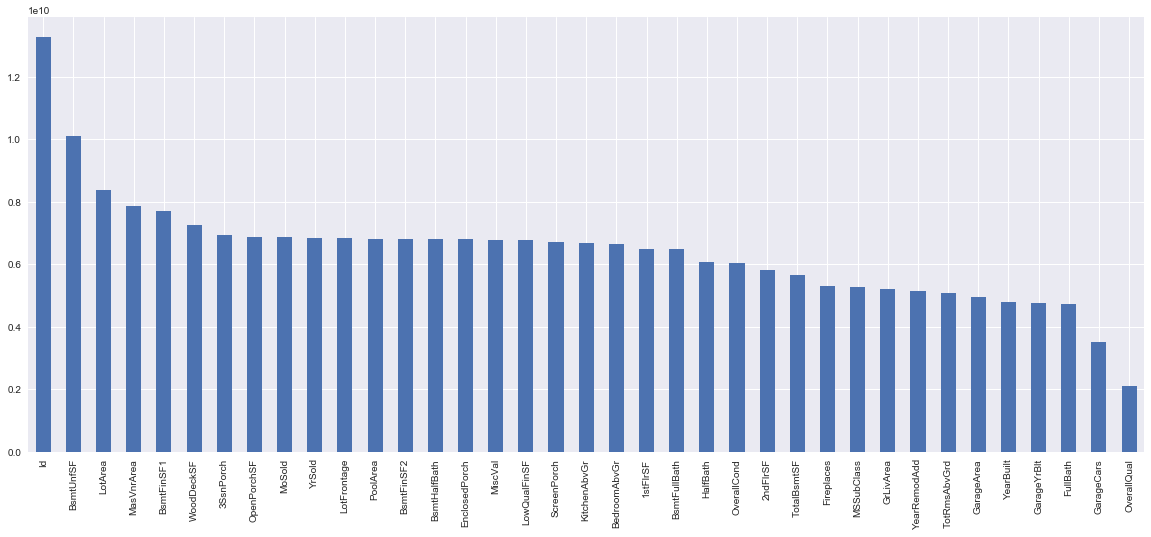

In [16]:
mse_values.sort_values(ascending=False).plot.bar(figsize=(20,8))

For regression, the smaller the mse, the better the model performance is. So in this case, we need to select from the right to the left.

For the mse, where to put the cut-off is arbitrary as well. It depends on how many features you would like to end up with.

Use this method in projects, particularly when you have an enormous amount of features and need to start reducing the feature space quickly.